# Lab 4 - YOLO

Błażej Nowicki

In [69]:

from ultralytics import YOLO
from PIL import Image
import random
import os

### 1. Using retrained model on supported categories

In [72]:
model = YOLO("yolov8x.pt")
model.predict("cat_dog.jpg", save=True, project=".", name="yolov8x")
pass


image 1/1 /home/blazej/Desktop/obrazy/lab4/cat_dog.jpg: 448x640 1 cat, 1 dog, 100.7ms
Speed: 1.3ms preprocess, 100.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)
Results saved to yolov8x


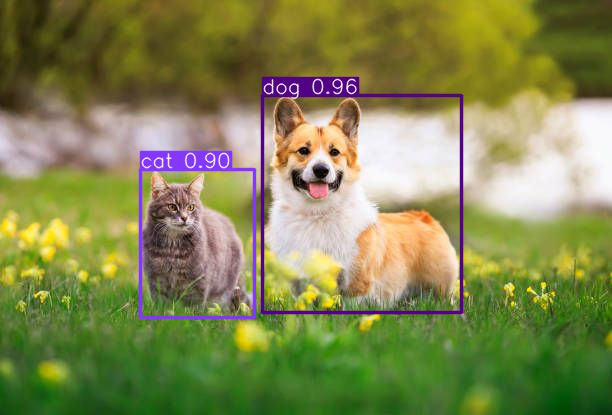

In [73]:
Image.open("yolov8x/cat_dog.jpg")

### 2. Create custom dataset with images of food

In [ ]:
%pip install boto3 botocore
!curl https://raw.githubusercontent.com/openimages/dataset/master/downloader.py -o downloader.py

In [3]:
# Get boxable class names
# !curl https://storage.googleapis.com/openimages/v7/oidv7-class-descriptions-boxable.csv -o metadata/class_names.csv
!cat metadata/class_names.csv | grep Food

/m/02wbm,Food
/m/03y6mg,Food processor


In [ ]:
CATEGORY = "/m/02wbm"

In [2]:
os.makedirs("metadata", exist_ok=True)

In [ ]:
!curl https://storage.googleapis.com/openimages/v6/oidv6-train-annotations-bbox.csv -o metadata/train_boxes.csv
!curl https://storage.googleapis.com/openimages/v5/validation-annotations-bbox.csv -o metadata/validation_boxes.csv
!curl https://storage.googleapis.com/openimages/v5/test-annotations-bbox.csv -o metadata/test_boxes.csv

In [ ]:
DATASET_PATH = "datasets/food"

In [ ]:
os.makedirs(DATASET_PATH + "/train/images", exist_ok=True)
os.makedirs(DATASET_PATH + "/train/labels", exist_ok=True)
os.makedirs(DATASET_PATH + "/validation/images", exist_ok=True)
os.makedirs(DATASET_PATH + "/validation/labels", exist_ok=True)

In [ ]:
def get_metadata(set: str):
    assert set in ["train", "validation", "test"]

    metadata = []

    with open(f"metadata/{set}_boxes.csv", "r") as file:
        lines = file.readlines()[1:]
        for line in lines:
            fields = line.strip().split(",")
            if len(fields) > 1 and fields[2] == CATEGORY:
                metadata.append(fields)
    
    return metadata

In [ ]:
def prepare_labels_and_ids(set: str, metadata: list[list[str]], size: int):
    assert set in ["train", "validation", "test"]
    labels: dict[str, list[str]] = {}

    for fields in metadata:
        xmin, xmax, ymin, ymax = map(float, fields[4:8])
        image_id = fields[0]

        x = (xmin + xmax) / 2
        y = (ymin + ymax) / 2
        w = xmax - xmin
        h = ymax - ymin

        row = f"0 {x} {y} {w} {h}\n"

        if image_id in labels:
            labels[image_id].append(row)
        else:
            labels[image_id] = [row]

    selected_images = list(labels.items())[:size]

    for id, rows in selected_images:
        with open(f"{DATASET_PATH}/{set}/labels/{id}.txt", "w") as file:
            file.writelines(rows)


    ids = [f"{set}/{id}\n" for id, _ in selected_images]

    with open(f"{DATASET_PATH}/{set}/ids.txt", "w") as file:
        file.writelines(ids)

In [ ]:
metadata = get_metadata("train")
prepare_labels_and_ids("train", metadata, 2000)

In [ ]:
!python downloader.py datasets/food/train/ids.txt --download_folder datasets/food/train/images --num_processes 5

In [ ]:
metadata = get_metadata("validation")
prepare_labels_and_ids("validation", metadata, 200)

In [ ]:
!python downloader.py datasets/food/validation/ids.txt --download_folder datasets/food/validation/images --num_processes 5

In [4]:
config = '''\
train: ./food/train
val: ./food/validation
nc: 1 
names: ['food']
'''

with open("food.yaml", "w") as f:
    f.write(config)

In [1]:
from ultralytics import YOLO
import torch
torch.backends.cudnn.enabled = False

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model. change this to the model you want to use, n, s, l etc. (only ending)

# Train the model
results = model.train(data=f"food.yaml", epochs=10)


Ultralytics YOLOv8.0.212 🚀 Python-3.9.18 torch-2.1.0 CUDA:0 (NVIDIA GeForce GTX 1650, 3906MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=food.yaml, epochs=10, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, stream_buffer=False, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fals

train: Scanning /home/blazej/Desktop/obrazy/lab4/datasets/food/train/labels.cache... 2000 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2000/2000 [00:00<?, ?it/s]
val: Scanning /home/blazej/Desktop/obrazy/lab4/datasets/food/validation/labels.cache... 200 images, 0 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train2
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.62G      1.474       2.39      1.543         74        640: 100%|██████████| 125/125 [03:14<00:00,  1.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:07<00:00,  1.01s/it]

                   all        200        324       0.27      0.327      0.183     0.0637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.68G      1.635      2.134      1.653         33        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200        324      0.152      0.203     0.0805      0.031



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.69G       1.68      2.032      1.714         48        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200        324      0.442      0.398      0.295      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.63G      1.688      1.909      1.716         48        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200        324      0.652      0.475      0.497      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.67G      1.645      1.842      1.696         52        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200        324      0.439      0.389       0.32       0.17



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.84G      1.581      1.748       1.63         45        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200        324      0.493      0.389      0.347      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.72G      1.532      1.692      1.596         50        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200        324      0.624      0.477      0.516      0.333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10       2.7G      1.491      1.605      1.573         45        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.01it/s]

                   all        200        324      0.591      0.495       0.45      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.66G      1.438      1.528      1.518         35        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        200        324      0.532      0.525      0.495      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.73G      1.416      1.457      1.505         54        640: 100%|██████████| 125/125 [03:21<00:00,  1.61s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.02it/s]

                   all        200        324      0.569      0.497      0.483       0.32



10 epochs completed in 0.578 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 6.2MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.212 🚀 Python-3.9.18 torch-2.1.0 CUDA:0 (NVIDIA GeForce GTX 1650, 3906MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:06<00:00,  1.03it/s]


                   all        200        324      0.623      0.475      0.516      0.333
Speed: 0.5ms preprocess, 30.2ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train2


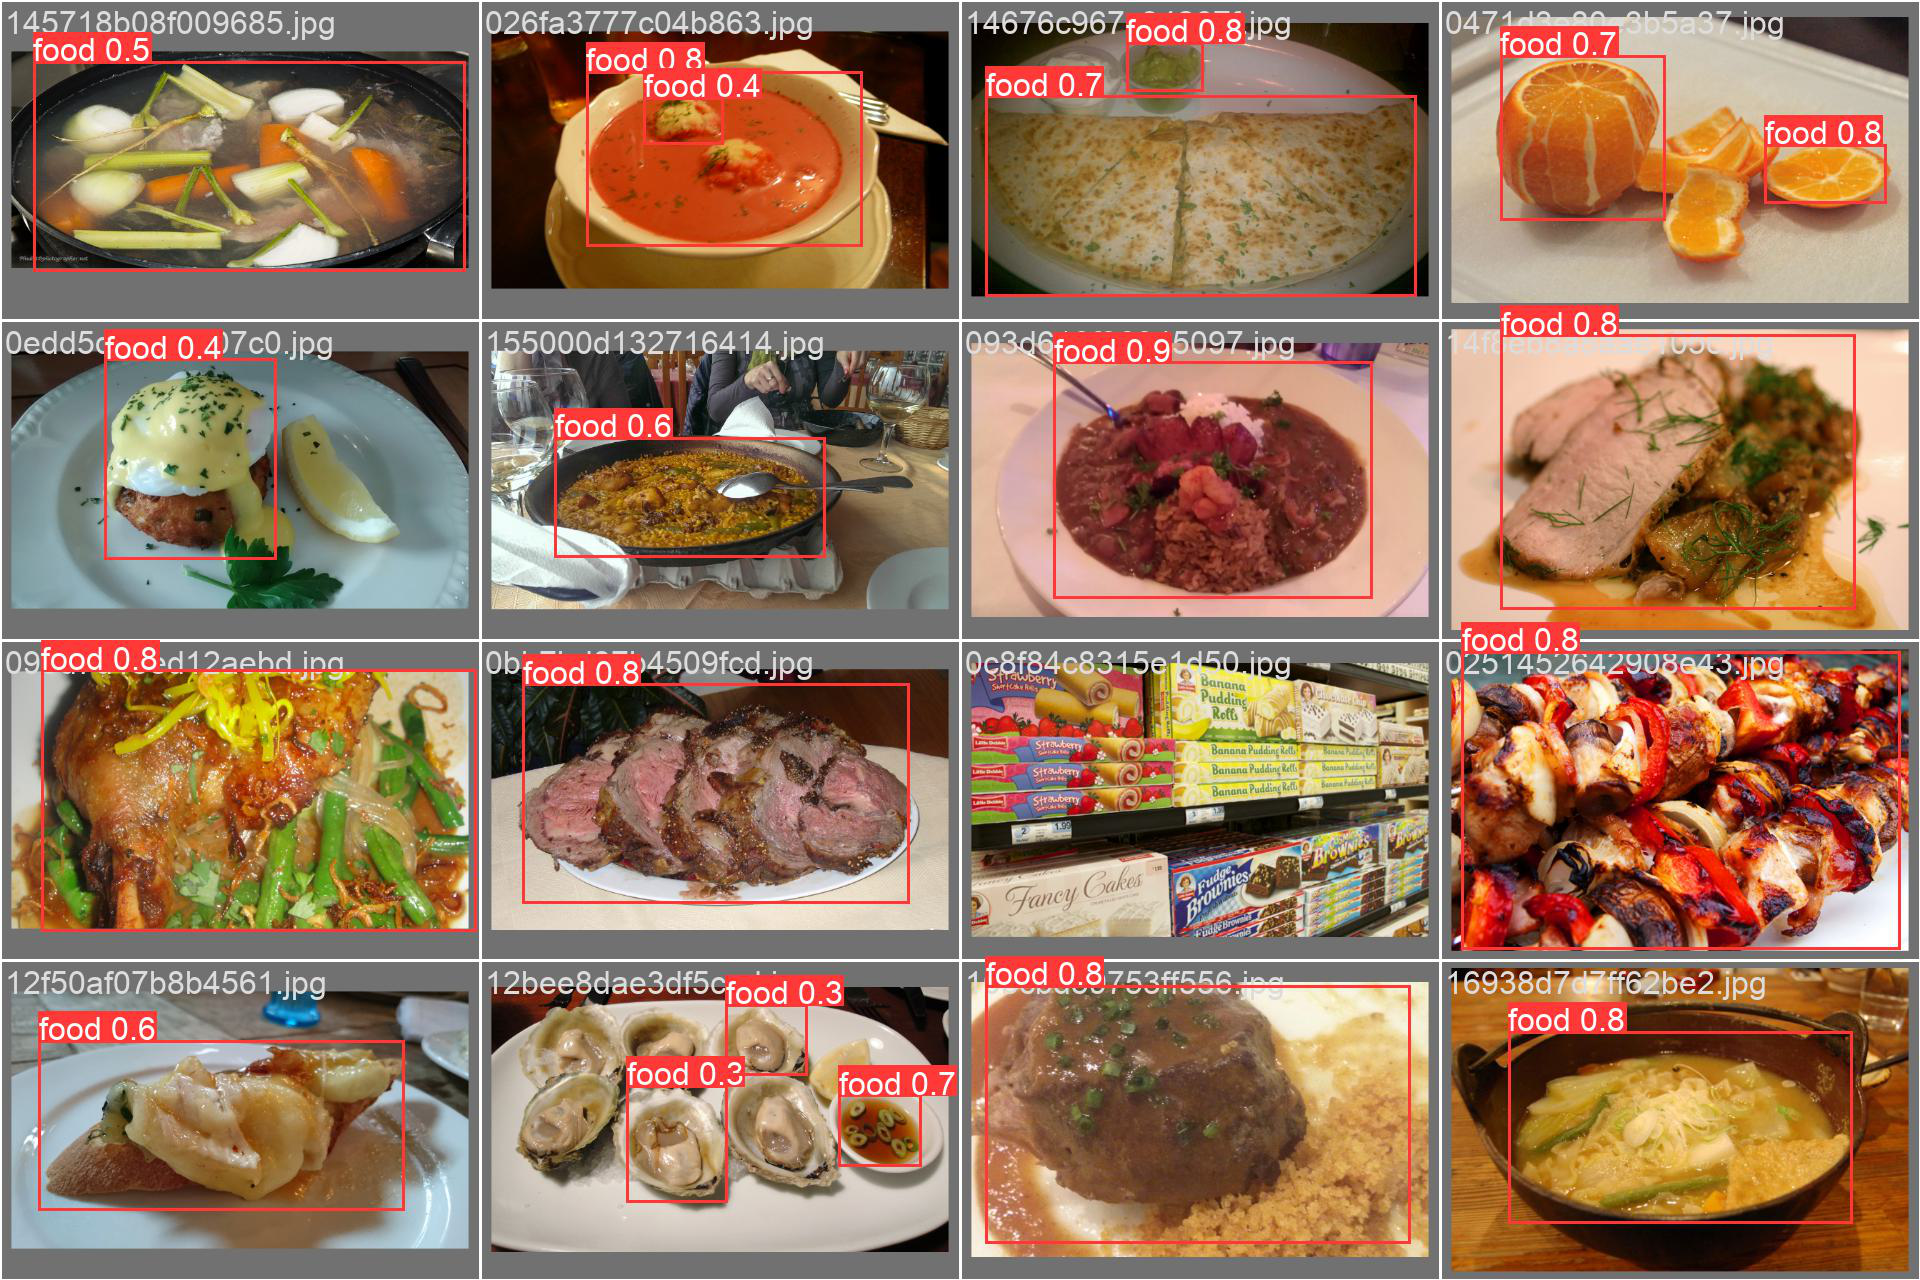

In [62]:
from PIL import Image
Image.open("runs/detect/train2/val_batch0_pred.jpg")

In [77]:
import os
import random
from ultralytics import YOLO
import cv2
from matplotlib import pyplot as plt

def blur_food(image_path):
    model = YOLO("runs/detect/train2/weights/last.pt")
    preds = model.predict(image_path)

    boxes = preds[0].boxes

    image = cv2.imread(image_path)

    for box in boxes:
        x, y, w, h = map(int, box.xywh.tolist()[0])
        x = x - w//2
        y = y - h//2
        image[y:y+h, x:x+w] = cv2.GaussianBlur(image[y:y+h, x:x+w], (15, 15),cv2.BORDER_DEFAULT)

    plt.figure(figsize = (15,10))
    plt.imshow(image[:, :, ::-1], interpolation='nearest')


image 1/1 /home/blazej/Desktop/obrazy/lab4/datasets/food/validation/images/1681f749e331106f.jpg: 640x448 3 foods, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


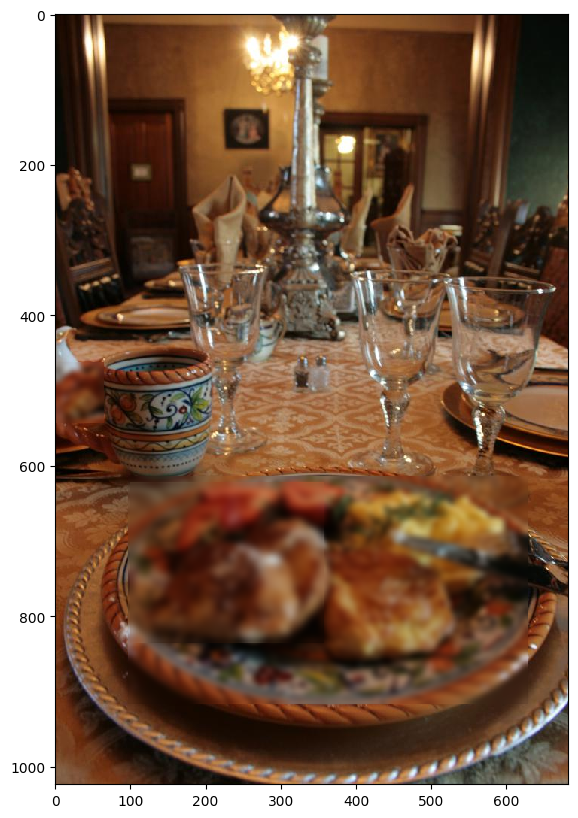

In [76]:
blur_food("datasets/food/validation/images/1681f749e331106f.jpg")


image 1/1 /home/blazej/Desktop/obrazy/lab4/datasets/food/validation/images/0550b879165d4392.jpg: 640x640 17 foods, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


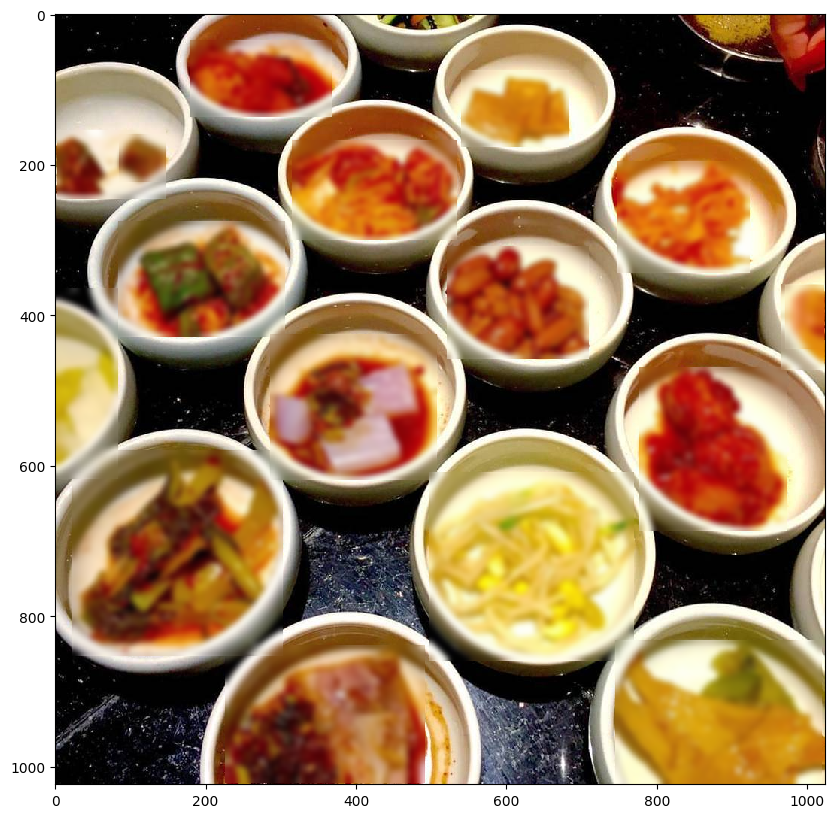

In [78]:
blur_food("datasets/food/validation/images/0550b879165d4392.jpg")


image 1/1 /home/blazej/Desktop/obrazy/lab4/datasets/food/validation/images/0b6227bb06345402.jpg: 640x448 2 foods, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)


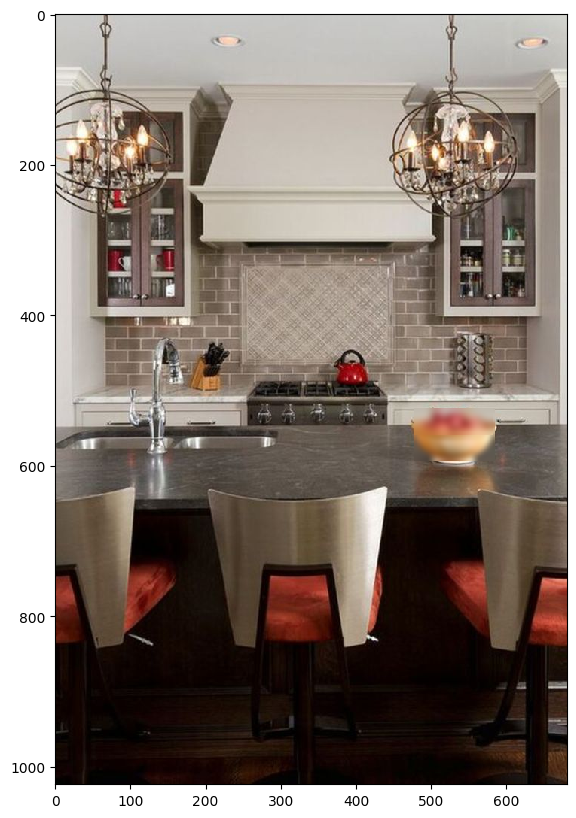

In [79]:
blur_food("datasets/food/validation/images/0b6227bb06345402.jpg")